# 2023 Holidays

<font size="4">2023 has not been an easy year. But we got through it and now offer an exploration of its holidays — the days when we had the opportunity to relax and spend time with family, friends, pets, or just ourselves.</font>

### Table of contents

- [1. Imports and initializations](#imports)
- [2. Data preparation](#data-preparation)
- [3. Visualizations](#visualizations)

<a id="imports"></a>
### 1. Imports and initializations

In [1]:
import sys
!conda install --yes --prefix {sys.prefix} colorcet

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda




In [2]:
import colorcet as cc

from lets_plot import *
from lets_plot.mapping import as_discrete
from lets_plot.geo_data import *

The geodata is provided by © OpenStreetMap contributors and is made available here under the Open Database License (ODbL).



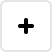
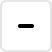
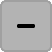
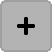
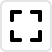
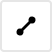
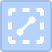
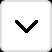
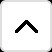
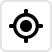
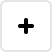
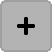
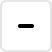
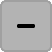
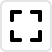
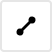
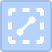
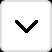
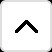
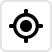

In [3]:
LetsPlot.setup_html()

In [4]:
def generate_month_colors(colormap):
    import numpy as np
    n = 12
    colors = [colormap[i] for i in np.linspace(0, len(colormap) - 1, n, dtype=int)]
    months = ['January', 'February', 'March', 'April', 'May', 'June', \
              'July', 'August', 'September', 'October', 'November', 'December']
    return {months[i]: colors[i] for i in range(n)}

top_size = 10
month_color = generate_month_colors(cc.gouldian)
religion_color = {
    "Orthodox": "#8856a7",
    "Christian": "#e6550d",
    "Hebrew": "#2ca25f",
    "Muslim": "#3182bd",
    "Hinduism": "#fa9fb5",
}

<a id="data-preparation"></a>
### 2. Data preparation

In [5]:
def read_data():
    import os
    import pandas as pd
    data_dir = "data/countries"
    paths = (os.path.join(data_dir, f) for f in os.listdir(data_dir))
    dfs = []
    for file_path in filter(os.path.isfile, paths):
        dfs.append(pd.read_csv(file_path))
    return pd.concat(dfs, ignore_index=True)

def get_data():
    import pandas as pd
    name_replace = {
        "New Year": "New Year's Day",
    }
    type_replace = {
        "['Season']": "Season",
        "['Clock change/Daylight Saving Time']": "DST",
        "['Sporting event']": "Sport",
    }
    df = pd.read_csv("data/holidays.csv")
    df.columns = ["date", "holiday_name" ,"type", "country_name", "country_code"]
    df["date"] = pd.to_datetime(df["date"], format='mixed', utc=True)
    df["month"] = df["date"].dt.month
    df["month_name"] = pd.Categorical(
        df["date"].dt.month_name(), 
        categories=list(month_color.keys()), 
        ordered=True
    )
    df["day_of_year"] = df["date"].dt.dayofyear
    df["day_of_month"] = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.dayofweek
    df["day_of_week_name"] = df["date"].dt.day_name()
    df["date_name"] = df["month_name"].str.cat(df["day_of_month"].astype(str), sep=", ")
    df["holiday_name"] = df["holiday_name"].replace(name_replace)
    df["is_national"] = df["type"].str.contains("'National holiday'").map({True: "yes", False: "no"})
    df["religion"] = df["type"].str.extract(r"(Orthodox|Christian|Hebrew|Muslim|Hinduism)")
    df["is_religious"] = (~df["religion"].isna()).map({True: "yes", False: "no"})
    df["holiday_type"] = df["type"].map(type_replace).fillna("Holiday").astype(str)
    df.drop(columns=["type", "country_code"], inplace=True)
    df.drop_duplicates(subset=["country_name", "holiday_name", "day_of_year"], inplace=True)
    return df

def filter_df(df, col, value):
    result = df[df[col] == value].reset_index(drop=True)
    result.drop(columns=[col], inplace=True)
    return result

def get_distinct_holidays_df(df):
    return df.drop_duplicates(subset=["holiday_name", "day_of_year"]).reset_index(drop=True)

def get_countries_gdf(df, country_col):
    return geocode_countries(df[country_col].unique()).ignore_not_found().inc_res().get_boundaries()

def get_top_df(df, col):
    return df[col].value_counts().to_frame().reset_index().iloc[:top_size]

In [6]:
full_df = get_data()
print(full_df.shape)
full_df.head()

(7098, 14)


date          holiday_name country_name  month  \
0 2023-02-15 00:00:00+00:00        Liberation Day  Afghanistan      2   
1 2023-03-20 21:24:20+00:00         March Equinox  Afghanistan      3   
2 2023-03-21 00:00:00+00:00                Nauruz  Afghanistan      3   
3 2023-03-23 00:00:00+00:00  First Day of Ramadan  Afghanistan      3   
4 2023-04-22 00:00:00+00:00           Eid al-Fitr  Afghanistan      4   

  month_name  day_of_year  day_of_month  day_of_week day_of_week_name  \
0   February           46            15            2        Wednesday   
1      March           79            20            0           Monday   
2      March           80            21            1          Tuesday   
3      March           82            23            3         Thursday   
4      April          112            22            5         Saturday   

      date_name is_national religion is_religious holiday_type  
0  February, 15         yes      NaN           no      Holiday  
1     March, 20          no      NaN           no       Season  
2     March, 21          no      NaN           no      Holiday  
3     March, 23          no      NaN           no      Holiday  
4     April, 22         yes      NaN           no      Holiday

In [7]:
countries_gdf = get_countries_gdf(full_df, "country_name")
print(countries_gdf.shape)
countries_gdf.head()

(207, 3)


country   found name                                           geometry
0  Afghanistan  Afghanistan  MULTIPOLYGON (((60.87286 29.85855, 61.80162 30...
1      Albania      Albania  MULTIPOLYGON (((19.37279 41.85000, 19.40242 42...
2      Algeria      Algeria  MULTIPOLYGON (((-4.83333 25.00000, -8.66812 27...
3      Andorra      Andorra  MULTIPOLYGON (((1.72589 42.50270, 1.51284 42.4...
4       Angola       Angola  MULTIPOLYGON (((11.99615 -15.63033, 12.15321 -...

In [8]:
holidays_df = filter_df(full_df, "holiday_type", "Holiday")
print(holidays_df.shape)
holidays_df.head()

(6089, 13)


date          holiday_name country_name  month  \
0 2023-02-15 00:00:00+00:00        Liberation Day  Afghanistan      2   
1 2023-03-21 00:00:00+00:00                Nauruz  Afghanistan      3   
2 2023-03-23 00:00:00+00:00  First Day of Ramadan  Afghanistan      3   
3 2023-04-22 00:00:00+00:00           Eid al-Fitr  Afghanistan      4   
4 2023-04-23 00:00:00+00:00   Eid al-Fitr Holiday  Afghanistan      4   

  month_name  day_of_year  day_of_month  day_of_week day_of_week_name  \
0   February           46            15            2        Wednesday   
1      March           80            21            1          Tuesday   
2      March           82            23            3         Thursday   
3      April          112            22            5         Saturday   
4      April          113            23            6           Sunday   

      date_name is_national religion is_religious  
0  February, 15         yes      NaN           no  
1     March, 21          no      NaN           no  
2     March, 23          no      NaN           no  
3     April, 22         yes      NaN           no  
4     April, 23         yes      NaN           no

In [9]:
distinct_holidays_df = get_distinct_holidays_df(holidays_df)
print(distinct_holidays_df.shape)
distinct_holidays_df.head()

(3177, 13)


date          holiday_name country_name  month  \
0 2023-02-15 00:00:00+00:00        Liberation Day  Afghanistan      2   
1 2023-03-21 00:00:00+00:00                Nauruz  Afghanistan      3   
2 2023-03-23 00:00:00+00:00  First Day of Ramadan  Afghanistan      3   
3 2023-04-22 00:00:00+00:00           Eid al-Fitr  Afghanistan      4   
4 2023-04-23 00:00:00+00:00   Eid al-Fitr Holiday  Afghanistan      4   

  month_name  day_of_year  day_of_month  day_of_week day_of_week_name  \
0   February           46            15            2        Wednesday   
1      March           80            21            1          Tuesday   
2      March           82            23            3         Thursday   
3      April          112            22            5         Saturday   
4      April          113            23            6           Sunday   

      date_name is_national religion is_religious  
0  February, 15         yes      NaN           no  
1     March, 21          no      NaN           no  
2     March, 23          no      NaN           no  
3     April, 22         yes      NaN           no  
4     April, 23         yes      NaN           no

In [10]:
national_holidays_df = filter_df(full_df, "is_national", 'yes')
print(national_holidays_df.shape)
national_holidays_df.head()

(3365, 13)


date         holiday_name country_name  month  \
0 2023-02-15 00:00:00+00:00       Liberation Day  Afghanistan      2   
1 2023-04-22 00:00:00+00:00          Eid al-Fitr  Afghanistan      4   
2 2023-04-23 00:00:00+00:00  Eid al-Fitr Holiday  Afghanistan      4   
3 2023-04-24 00:00:00+00:00  Eid al-Fitr Holiday  Afghanistan      4   
4 2023-04-28 00:00:00+00:00   Afghan Victory Day  Afghanistan      4   

  month_name  day_of_year  day_of_month  day_of_week day_of_week_name  \
0   February           46            15            2        Wednesday   
1      April          112            22            5         Saturday   
2      April          113            23            6           Sunday   
3      April          114            24            0           Monday   
4      April          118            28            4           Friday   

      date_name religion is_religious holiday_type  
0  February, 15      NaN           no      Holiday  
1     April, 22      NaN           no      Holiday  
2     April, 23      NaN           no      Holiday  
3     April, 24      NaN           no      Holiday  
4     April, 28      NaN           no      Holiday

In [11]:
distinct_national_holidays_df = get_distinct_holidays_df(national_holidays_df)
print(distinct_national_holidays_df.shape)
distinct_national_holidays_df.head()

(1670, 13)


date         holiday_name country_name  month  \
0 2023-02-15 00:00:00+00:00       Liberation Day  Afghanistan      2   
1 2023-04-22 00:00:00+00:00          Eid al-Fitr  Afghanistan      4   
2 2023-04-23 00:00:00+00:00  Eid al-Fitr Holiday  Afghanistan      4   
3 2023-04-24 00:00:00+00:00  Eid al-Fitr Holiday  Afghanistan      4   
4 2023-04-28 00:00:00+00:00   Afghan Victory Day  Afghanistan      4   

  month_name  day_of_year  day_of_month  day_of_week day_of_week_name  \
0   February           46            15            2        Wednesday   
1      April          112            22            5         Saturday   
2      April          113            23            6           Sunday   
3      April          114            24            0           Monday   
4      April          118            28            4           Friday   

      date_name religion is_religious holiday_type  
0  February, 15      NaN           no      Holiday  
1     April, 22      NaN           no      Holiday  
2     April, 23      NaN           no      Holiday  
3     April, 24      NaN           no      Holiday  
4     April, 28      NaN           no      Holiday

<a id="visualizations"></a>
### 3. Visualizations

In [12]:
def get_map_plot(data, title, trans=None):
    return ggplot() + \
        geom_livemap(const_size_zoomin=0) + \
        geom_map(aes(fill="count"), data=data, show_legend=False, \
                 map=countries_gdf, map_join=["country_name", "country"],
                 tooltips=layer_tooltips().title("@country_name")\
                          .format("@count", 'd').line("holidays count|@count")) + \
        scale_fill_brewer(type='seq', palette='PuRd', trans=trans) + \
        ggtitle(title) + \
        theme_void()

gggrid([
    get_map_plot(holidays_df["country_name"].value_counts().to_frame().reset_index(), title="All holidays", trans='sqrt'),
    get_map_plot(national_holidays_df["country_name"].value_counts().to_frame().reset_index(), title="Only national holidays"),
    get_map_plot(holidays_df[
                     holidays_df["holiday_name"].str.contains("New Year", case=False)
                 ]["country_name"].value_counts().to_frame().reset_index(), title="New Year holidays"),
], ncol=2)

The first plot tells us that if you count all holidays (not just weekends), the US has a suspiciously high number of holidays (more than the number of days in a year).

The second plot shows how many national holidays (usually it is a weekends) there are.

The third plot shows who has how many New Year's holidays (not necessarily weekends).

In [13]:
us_holidays = holidays_df[holidays_df["country_name"] == "United States"].reset_index(drop=True)

ggplot(us_holidays) + \
    geom_dotplot(aes("day_of_year", fill="month_name"), \
                 binwidth=7, boundary=5, show_legend=False, \
                 tooltips=layer_tooltips().title("@month_name")\
                          .format("@..count..", 'd').line("week holidays count|@..count..")) + \
    scale_fill_manual(values=month_color) + \
    xlab("day of year") + ylab("count") + \
    ggtitle("US holidays")

Let's look closer to the US. Here are all the holidays that there are (by week).

In [14]:
ggplot(distinct_national_holidays_df) + \
    geom_density(aes("day_of_year"), fill="#2c7fb8") + \
    xlab("day of year") + \
    ggtitle("Distribution of national holidays during the year")

Over the course of a year, the greatest density of holidays is reached roughly between the 100th and 130th day.

In [15]:
ggplot(distinct_national_holidays_df) + \
    geom_density(aes("day_of_month", fill="..quantile..")) + \
    scale_fill_brewer(type='seq', palette='YlOrRd') + \
    facet_wrap(facets="month_name", order=0) + \
    xlab("day of month") + \
    ggtitle("Distribution of national holidays per month")

And here's how the holidays are distributed in each month. For some reason, they are not usually concentrated around the median.

In [16]:
ggplot(distinct_national_holidays_df) + \
    geom_pie(aes(fill=as_discrete("month_name", order_by="month")), \
             hole=.65, size=35, color='black', spacer_color='black', \
             stroke=2, show_legend=False, \
             tooltips=layer_tooltips().line("@..proppct.."), \
             labels=layer_labels().line("@month_name").size(10)) + \
    scale_fill_manual(values=month_color) + \
    ggtitle("Proportion of holidays count per month") + \
    theme_void() + ggsize(600, 400)

The least festive month is December and the most festive month is April.

In [17]:
top_of_days_with_holiday_df = get_top_df(national_holidays_df, "day_of_year").sort_values(by="day_of_year").merge(
    national_holidays_df[["day_of_year", "date_name"]].drop_duplicates(), on="day_of_year"
)

ggplot(top_of_days_with_holiday_df) + \
    geom_bar(aes("count", as_discrete("day_of_year")), stat='identity', \
             orientation='y', fill="#2c7fb8", \
             labels=layer_labels().line("@date_name")) + \
    ggtitle("Number of all holidays in this day") + \
    theme(axis_title_y='blank', axis_text_y='blank')

If we look at which days of the year have the most national holidays (from all countries), the 1st of January is the most festive. 25 December and 1 May are not far behind.

In [18]:
ggplot(distinct_national_holidays_df) + \
    geom_pie(aes(fill=as_discrete("day_of_week_name", order_by="day_of_week")), \
             hole=.3, size=35, color='black', spacer_color='black', \
             stroke=2, show_legend=False, \
             tooltips=layer_tooltips().line("@..proppct.."), \
             labels=layer_labels().line("@day_of_week_name")) + \
    ggtitle("Proportion of holidays count per week") + \
    theme_void() + ggsize(600, 400)

Looking at the distribution of national holidays by day of the week (relevant only for the year 2023), the most holidays fall on Monday and the least on Saturday.

In [19]:
top_of_holidays_df = national_holidays_df[national_holidays_df["holiday_name"].isin(
    get_top_df(national_holidays_df, "holiday_name")["holiday_name"].to_list()
)].sort_values(by="day_of_year").reset_index(drop=True)

ggplot(top_of_holidays_df) + \
    geom_count(aes("day_of_year", "holiday_name", group="date_name"), \
               alpha=.5, color="#2c7fb8", show_legend=False, \
               tooltips=layer_tooltips().title("@holiday_name")\
                        .line("date|@date_name")\
                        .line("number of countries|@..n..")) + \
    scale_size(range=[2, 20]) + \
    xlab("day of year") + ylab("holiday name") + \
    ggtitle("Top {0} national holidays".format(top_size)) + \
    ggsize(1000, 400)

These are the top 10 most popular national holidays. The most common is New Year's Day. For some holidays, the date can float - depending on the country. The most dispersed holiday is Independence Day - of course it is different for every country.

This plot should be taken with caution - I can only distinguish holidays by name, but it happens in the raw data that essentially the same holiday is named slightly differently in different countries.

In [20]:
def get_religious_pie(df, title, show_legend):
    return ggplot(df) + \
        geom_pie(aes(fill="is_religious"), size=20, color='black', \
                 spacer_color='black', stroke=2, show_legend=show_legend, \
                 tooltips='none', labels=layer_labels().line("@..proppct..")) + \
        scale_fill_discrete(name="is religious") + \
        ggtitle(title) + \
        theme_void()

gggrid([
    get_religious_pie(distinct_holidays_df, "Overall holidays", False),
    get_religious_pie(distinct_national_holidays_df, "National holidays", True),
])

Most holidays are secular. Especially if we consider only national holidays.

In [21]:
def get_religions_pie(df, title, show_legend):
    return ggplot(df[df["is_religious"] == "yes"]) + \
        geom_pie(aes(fill=as_discrete("religion", order_by="..count..")), \
                 hole=.5, size=30, color='black', spacer_color='black', \
                 stroke=2, show_legend=show_legend, tooltips='none', \
                 labels=layer_labels().line("@..proppct..")) + \
        scale_fill_manual(values=religion_color) + \
        ggtitle(title) + \
        theme_void()

gggrid([
    get_religions_pie(distinct_holidays_df, "Overall religious holidays", False),
    get_religions_pie(distinct_national_holidays_df, "Overall national religious holidays", True),
])

If we consider only religious holidays, then Hebrew has the most of them. However, if we look only at national holidays, then the greatest diversity is among the Orthodox.

In [22]:
def get_lollipop_data():
    import numpy as np
    n = 10
    x = np.linspace(-1, 1, 4 * n)
    y = [.65, .75] * 2 * n
    c = ["#f03b20", "#31a354", "#3182bd", "#ffeda0"] * n
    return dict(x=x, y=y, c=c)

text = """
2024 is coming and Lets-Plot team wishes you all the best,
especially more time for yourself
while the AI does all the boring
and routine part of the work for you!
"""

ggplot() + \
    geom_text(x=0, y=0, label=text, size=16, family="Times", fontface='bold', color="#006837") + \
    geom_lollipop(aes('x', 'y', fill='c'), data=get_lollipop_data(), intercept=1, shape=21, show_legend=False) + \
    scale_fill_identity() + \
    xlim(-1, 1) + ylim(-1, 1) + \
    ggsize(1000, 300) + \
    theme_void()